In [ ]:
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision.transforms as transforms


import os

from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# folder_path = '###'
# files = os.listdir(folder_path)


# Load data from Kaggle
{"username":"remcdl","key":"7499823d00bfc21b2c57c385ad1bfa45"}

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"remcdl","key":"7499823d00bfc21b2c57c385ad1bfa45"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip /content/emotion-detection-fer.zip -d kaggle_data

Streaming output truncated to the last 5000 lines.
  inflating: kaggle_data/train/sad/im37.png  
  inflating: kaggle_data/train/sad/im370.png  
  inflating: kaggle_data/train/sad/im3700.png  
  inflating: kaggle_data/train/sad/im3701.png  
  inflating: kaggle_data/train/sad/im3702.png  
  inflating: kaggle_data/train/sad/im3703.png  
  inflating: kaggle_data/train/sad/im3704.png  
  inflating: kaggle_data/train/sad/im3705.png  
  inflating: kaggle_data/train/sad/im3706.png  
  inflating: kaggle_data/train/sad/im3707.png  
  inflating: kaggle_data/train/sad/im3708.png  
  inflating: kaggle_data/train/sad/im3709.png  
  inflating: kaggle_data/train/sad/im371.png  
  inflating: kaggle_data/train/sad/im3710.png  
  inflating: kaggle_data/train/sad/im3711.png  
  inflating: kaggle_data/train/sad/im3712.png  
  inflating: kaggle_data/train/sad/im3713.png  
  inflating: kaggle_data/train/sad/im3714.png  
  inflating: kaggle_data/train/sad/im3715.png  
  inflating: kaggle_data/train/sad/im3716

In [ ]:
# Define class EmotionDataset

class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Map each emotion to indices from 0 ~ 6
        self.classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for label in self.classes:
            class_dir = os.path.join(self.root_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Map label to index
        label_idx = self.class_to_idx[label]
        return image, label_idx

In [ ]:
# Get indicies of the targeted classes

def get_relevant_indices(dataset, classes, target_classes):
    # dataset = [(img1, 0), (img2, 1), (img3, 2), (img4, 0), (img5, 1)]

    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'A'
        if label_class in target_classes:
            indices.append(i)

    # if target class being class0 & class1, then indices = [0, 1, 3, 4]
    return indices

In [ ]:
# Load and split data
def get_data_loader(train_directory, test_directory, target_classes, batch_size):
    """ Loads images of facial emotions, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """
    # Letters for classification
    classes = ('angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised')

    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
         [transforms.Grayscale(1),
          transforms.Resize((48, 48)),
         transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])

    ########################################################################
    # Load Gesture training data using the defined gesture dataset class above
    train_dataset = EmotionDataset(root_dir=train_directory, transform=transform)
    test_dataset = EmotionDataset(root_dir=test_directory, transform=transform)

    # Get the list of indices to sample from
    train_relevant_indices = get_relevant_indices(train_dataset, classes, target_classes)
    test_relevant_indices = get_relevant_indices(test_dataset, classes, target_classes)

    # Split train into 80% train, 20% validation, keep test data
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(train_relevant_indices)

    total_train_size = len(train_relevant_indices)

    train_split = int(total_train_size * 0.8)  # 80% for training
    val_split = int(total_train_size * 0.2)    # 20% for validation

    # split into training and validation indices
    relevant_train_indices = train_relevant_indices[:train_split]
    relevant_val_indices = train_relevant_indices[train_split:train_split + val_split]

    relevant_test_indices = test_relevant_indices

    ########################################################################
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)

    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=1, sampler=val_sampler)

    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    return train_loader, val_loader, test_loader, classes

In [ ]:
# Load the data in
train_loader, val_loader, test_loader, classes = get_data_loader(
    train_directory = '/content/kaggle_data/train',
    test_directory = '/content/kaggle_data/test',
    target_classes=['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'],
    batch_size=1) # 1 image per batch

print("Dataset loaded successfully.")

Dataset loaded successfully.


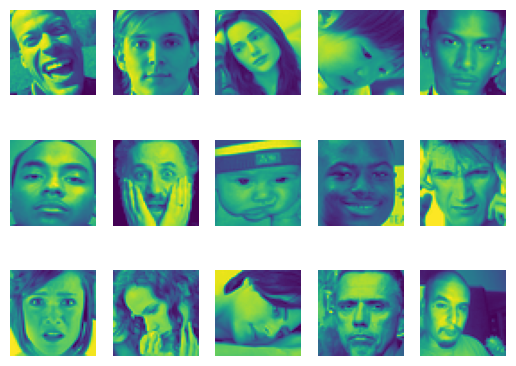

In [ ]:
# Sanity check: is the data loaded correctly?

k = 0
for images, labels in train_loader:
    # Only load the 1st image in `images` no matter the batch size
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

    # only load 15 images
    k += 1
    if k > 14:
        break

In [ ]:
# Load self-collected data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Process self-collected data
import cv2
import glob

base_path = '/content/drive/My Drive/APS360 Tut & Labs/Collected_Dataset'

images = {}
labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Load the pre-trained Haar Cascade model for face detection
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define transformation
transform = transforms.Compose(
         [transforms.Grayscale(1),
          transforms.Resize((48, 48)),
         transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])

for label in labels:
    # Initialize list to store images for the current label
    images[label] = []

    folder_path = os.path.join(base_path, label)
    image_paths = glob.glob(os.path.join(folder_path, '*.png'))

    for image_path in image_paths:
        # Open the image file
        img = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
        img_array = np.array(img)

        # Detect faces in the image
        faces = haar_cascade.detectMultiScale(img_array, scaleFactor=1.1, minNeighbors=20)

        # Crop the face(s) if detected
        for (x, y, w, h) in faces:

            # Wish to crop images to squares
            side_length = max(w, h)

            cx, cy = x + w // 2, y + h // 2
            x_new = max(cx - side_length // 2, 0)
            y_new = max(cy - side_length // 2, 0)

            # Crop the square from the original image
            cropped_face = img_array[y_new:y_new + side_length, x_new:x_new + side_length]

            face_pil = Image.fromarray(cropped_face)

            # Apply transformations
            face_tensor = transform(face_pil)
            images[label].append(face_tensor)

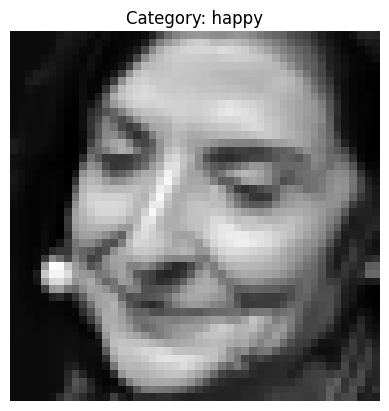

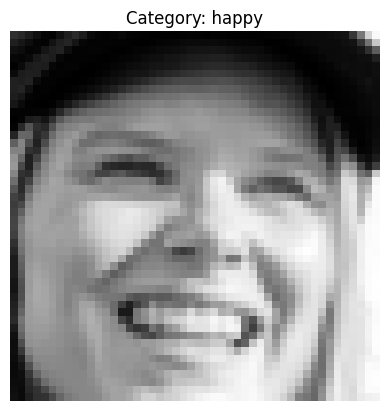

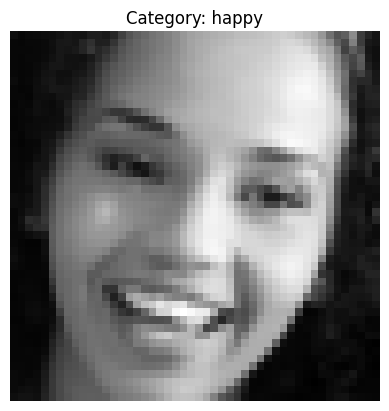

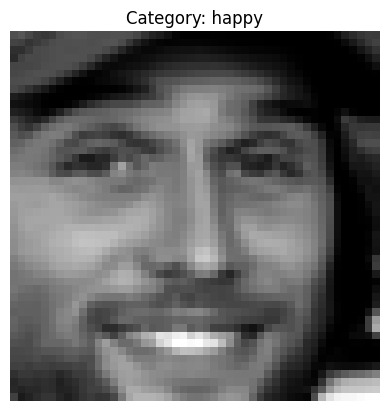

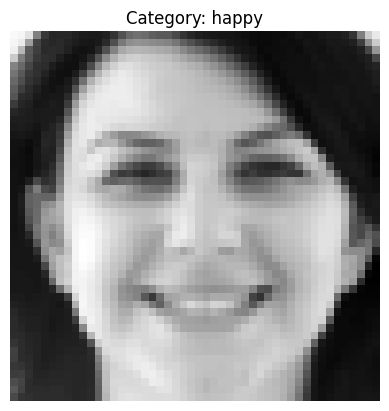

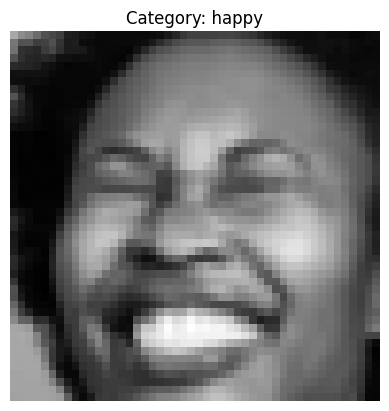

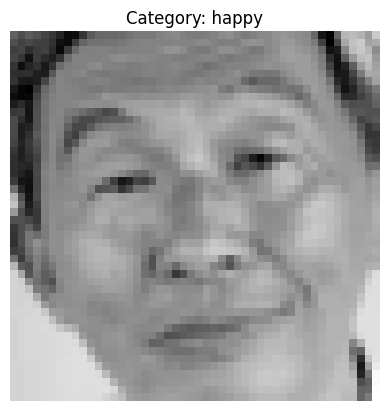

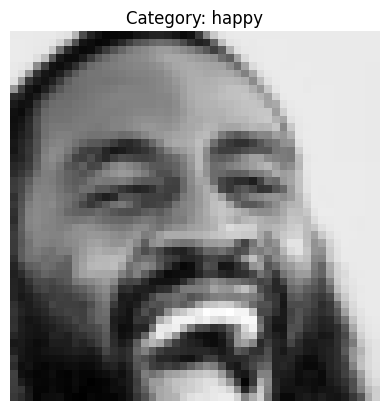

In [ ]:
# Example to visualize the first image from the 'happy' category
category = 'happy'

for img in images[category]:
    # Transpose the image array to move the color channel to the last dimension
    img_array = img.numpy()
    img_array = np.transpose(img_array, (1, 2, 0))

    # Plot the image using matplotlib
    plt.imshow(img_array, cmap='gray')
    plt.title(f'Category: {category}')
    plt.axis('off')  # Turn off the axis
    plt.show()